<a href="https://colab.research.google.com/github/psg-dsci/linux-administration/blob/main/gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import pandas as pd
import os


In [22]:
import kagglehub
ambarish_breakhis_path = kagglehub.dataset_download('ambarish/breakhis')
print("Dataset downloaded successfully.")


Dataset downloaded successfully.


In [23]:
# Load dataset CSV
csv_path = os.path.join(ambarish_breakhis_path, "Folds.csv")
df = pd.read_csv(csv_path)

# Define base path for images
image_base_path = os.path.join(ambarish_breakhis_path, "BreaKHis_v1")

# Get a sample image path
sample_image_filename = df.iloc[0]['filename']
sample_image_path = os.path.join(image_base_path, sample_image_filename)


In [24]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)


In [25]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array


In [26]:
img_array = preprocess_image(sample_image_path)
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


In [27]:
grad_model = Model(inputs=model.input, outputs=[model.get_layer("block5_conv3").output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    tape.watch(conv_outputs)  # Watch conv layer
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


In [28]:
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


<ipython-input-28-ece684738bc2>:3: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


In [29]:
orig_img = cv2.imread(sample_image_path)
orig_img = cv2.resize(orig_img, (224, 224))

# Resize heatmap and apply colormap
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay heatmap on image
superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap_colored, 0.4, 0)


<ipython-input-29-ff23e19aab3c>:6: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


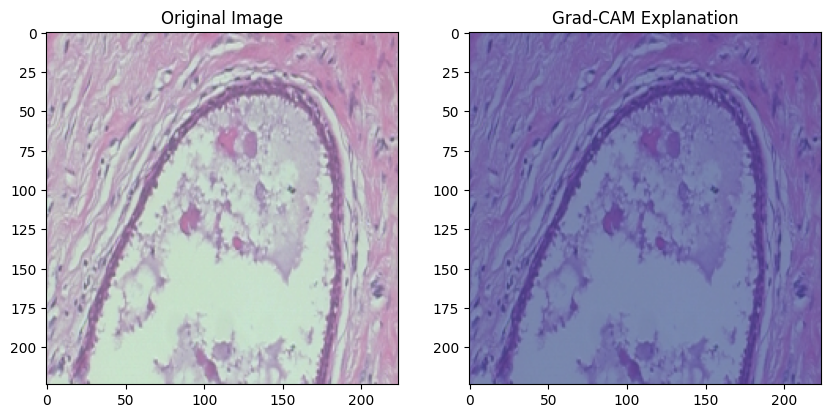

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Explanation")

plt.show()


In [31]:
!pip install opencv-python
!pip install tensorflow
!pip install shap
!pip install lime


In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import pandas as pd
import os
import shap
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image


In [33]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array


In [34]:
img_array = preprocess_image(sample_image_path)
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


In [35]:
grad_model = Model(inputs=model.input, outputs=[model.get_layer("block5_conv3").output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)


In [36]:
orig_img = cv2.imread(sample_image_path)
orig_img = cv2.resize(orig_img, (224, 224))

# Resize heatmap and overlay on original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
gradcam_output = cv2.addWeighted(orig_img, 0.6, heatmap_colored, 0.4, 0)


In [37]:
explainer = lime_image.LimeImageExplainer()

# Define LIME prediction function
def predict_fn(images):
    return model.predict(images)

# Explain image using LIME
explanation = explainer.explain_instance(img_array[0].astype('double'),
                                         predict_fn,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(pred_class, positive_only=True, num_features=10, hide_rest=False)
lime_output = mark_boundaries(temp, mask)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
shap_explainer = shap.GradientExplainer(model, img_array)
shap_values = shap_explainer.shap_values(img_array)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_23
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_23
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


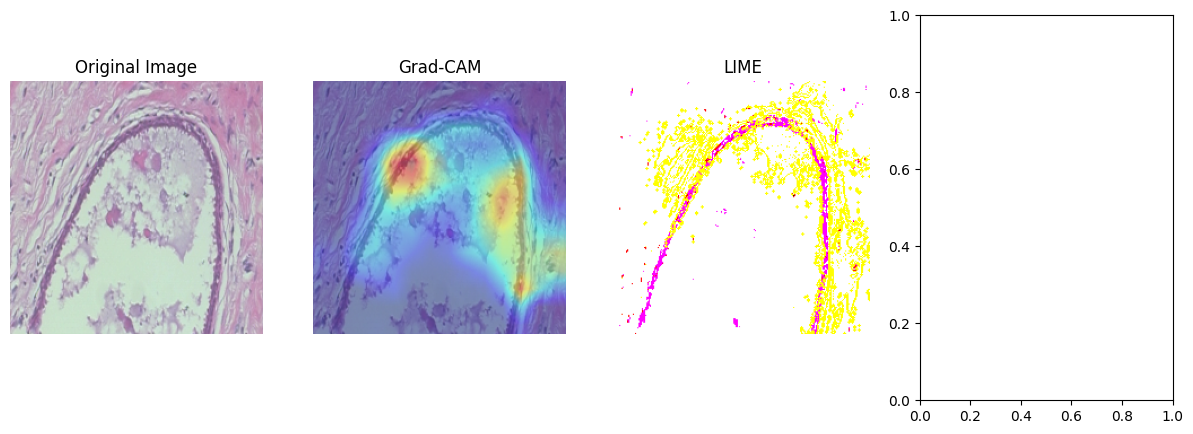

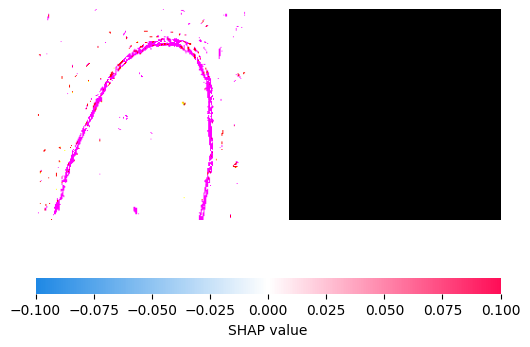

In [20]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Grad-CAM
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(gradcam_output, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis("off")

# LIME
plt.subplot(1, 4, 3)
plt.imshow(lime_output)
plt.title("LIME")
plt.axis("off")

# SHAP
plt.subplot(1, 4, 4)
shap.image_plot(shap_values, img_array)

plt.show()
